In [69]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from gvit.quadtree import QuadTree

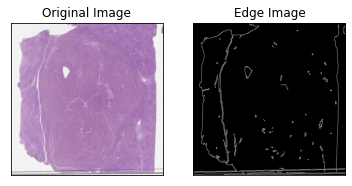

In [70]:
img = cv.imread('./dataset/paip/output_images_and_masks/128700-2019-01-00-03-01/rescaled_image_0_512x512.png')
grey_img = img
grey_img = cv.GaussianBlur(grey_img, (3,3),0)
edges = cv.Canny(grey_img, 100, 200)

plt.subplot(121),plt.imshow(grey_img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.savefig(fname="paip_canny.jpg")
plt.show()

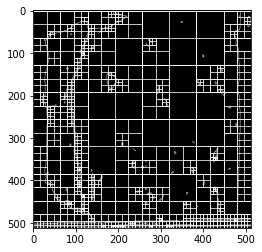

In [72]:
fig, ax = plt.subplots()
ax.imshow(edges, cmap = 'gray')

qdt = QuadTree(domain=edges, max_value=20, max_depth = 10)
qdt.draw(ax=ax)
plt.savefig(fname="paip_pachify.jpg")
plt.show()

In [68]:
# 4x4 => 904 patches
# 512/8 = 64*64 => 4096 patches  

patch_info = {}
print(qdt.count_patches(patch_info))
print(patch_info)
print(sum(patch_info.values()))


364
{'16*16': 150, '32*32': 118, '8*8': 72, '64*64': 24}
364


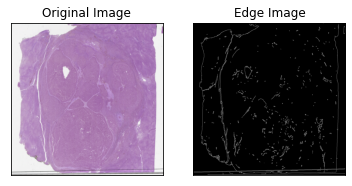

In [61]:
img = cv.imread('./dataset/paip/output_images_and_masks/128700-2019-01-00-03-01/rescaled_image_0_1024x1024.png')
grey_img = img
grey_img = cv.GaussianBlur(grey_img, (3,3),0)
edges = cv.Canny(grey_img, 100, 200)
resized_image = cv.resize(img, (1024,1024))

plt.subplot(121),plt.imshow(grey_img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.savefig(fname="paip_canny.jpg")
plt.show()

(Text(0.5, 1.0, 'resize Image'), ([], []), ([], []))

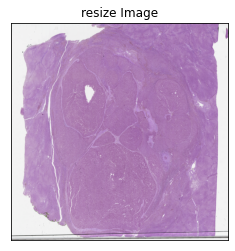

In [62]:
plt.imshow(resized_image)
plt.title('resize Image'), plt.xticks([]), plt.yticks([])

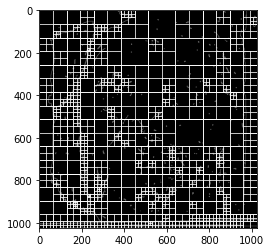

In [41]:
fig, ax = plt.subplots()
ax.imshow(edges, cmap = 'gray')

qdt = QuadTree(domain=edges, max_value=60, max_depth = 10)
qdt.draw(ax=ax)
plt.savefig(fname="paip_pachify.jpg")
plt.show()

In [42]:
# 8x8 => 424 patches
# 512/8 = 64*64 => 4096 patches  

patch_info = {}
print(qdt.count_patches(patch_info))
print(patch_info)
print(sum(patch_info.values()))

1000
{'16*16': 502, '32*32': 353, '64*64': 116, '8*8': 24, '128*128': 5}
1000


In [54]:
data = {'16*16': 502, '32*32': 353, '64*64': 116, '8*8': 24, '128*128': 5}

min_key = min((tuple(map(int, key.split('*'))), value) for key, value in data.items())[0]

min_key_list = list(min_key)

print(min_key_list)

[8, 8]


In [24]:
import os 
import glob 
from pathlib import Path

# patchify
 
def get_img_path(base="./dataset/exp/"):
    files = []
    for f in glob.glob(os.path.join(base, "*/*.jpeg")):
        files.append(f)
    return files

def transform(img):
    res = cv.resize(img, dsize=(512, 512), interpolation=cv.INTER_CUBIC)
    grey_img = res[:, :, 0]
    blur = cv.GaussianBlur(grey_img, (3,3),0)
    edge = cv.Canny(blur, 100, 200)
    return res, edge

# save patch sequence
def compress_mix_patches(qdt:QuadTree, img: np.array, to_size:tuple = (8,8,3)):
    h2,w2,c2 = to_size
    seq_patches = qdt.serialize(img)
    for i in range(len(seq_patches)):
        h1, w1, c1 = seq_patches[i].shape
        assert h1==w1, "Need squared input."
        # print(seq_patches[i].shape, seq_patches[i])
        step =int(h1/to_size[0])
        seq_patches[i] = seq_patches[i][::step,::step]
        assert seq_patches[i].shape == (h2,w2,c2), "Wrong shape {} get, need {}".format(seq_patches[i].shape, (h2,w2,c2))
    return seq_patches

def custom_patchify(base="./dataset/exp", to_size: tuple=(8,8,3)):
    img_path = get_img_path(base=base)
    patch_size = to_size[0]
    save_to = base+"_qdt"
    if not os.path.exists(save_to):
        os.makedirs(save_to)
        
    for i,p in enumerate(img_path):
        img = cv.imread(p)
        img, edge = transform(img)
        qdt = QuadTree(domain=edge)
        seq_patches = compress_mix_patches(qdt, img, to_size)
        seq_img = np.asarray(seq_patches)
        seq_img = np.reshape(seq_img,(patch_size, -1, 3))
        name = Path(p).parts[-2]
        cv.imwrite(save_to+"/{}_{}.jpeg".format(i, name), seq_img)

custom_patchify()
        